In [21]:
%reload_ext autoreload
%autoreload 2

%reload_ext autoreload
%autoreload 2
import sys; sys.path.append('..')
from src.data_utils import get_dataset_imagenet, imagenet_classes
from jupyter_preproc import smoothen, probs_to_softacc
import numpy as np
import time
import matplotlib.pyplot as plt
rng = np.random.default_rng(5)
import seaborn as sns
import matplotlib as mpl
from plot_utils import stacksimple

from scipy.stats import norm
import scipy
ppf = norm.ppf
cdf = norm.cdf

In [2]:
data_v2_resnet50 = np.load('/home/jupyter/dist-shift/processed/imagenet/resnet50/resnet50_imagenet_v2.npz', mmap_mode='r')
data_v2_densenet121 = np.load('/home/jupyter/dist-shift/processed/imagenet/densenet121/densenet121_imagenet_v2.npz', mmap_mode='r')
data_v2_densenet169 = np.load('/home/jupyter/dist-shift/processed/imagenet/densenet169/densenet169_imagenet_v2.npz', mmap_mode='r')

gname = 'imagenet_v2'
dataset = get_dataset_imagenet(gname)
ytest = dataset.targets
classes = imagenet_classes

datas = [data_v2_resnet50, data_v2_densenet121, data_v2_densenet169]


In [3]:
all_x = np.concatenate([data_v2_resnet50['x'], data_v2_densenet121['x'], data_v2_densenet169['x']])
all_v2 = np.concatenate([data_v2_resnet50['all_acc'], data_v2_densenet121['all_acc'], data_v2_densenet169['all_acc']])
p = np.poly1d(np.polyfit(ppf(all_x), ppf(all_v2), 1))
p

poly1d([ 0.90811717, -0.29363644])

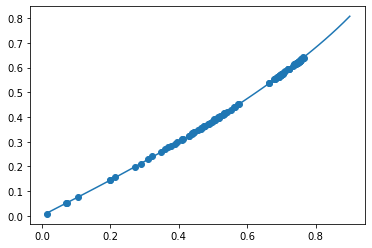

In [4]:
# the fit is nice
plt.scatter(all_x, all_v2)
xs = ppf(np.linspace(0.01, 0.9))
ys = cdf(p(xs))
plt.plot(np.linspace(0.01, 0.9), ys)

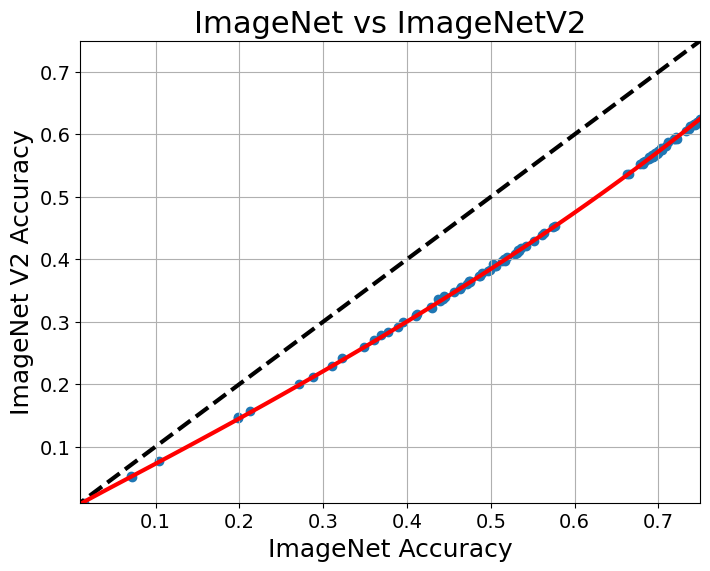

In [26]:
plt.style.use('default')

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.scatter(all_x, all_v2, color='tab:blue')
# for ind, dat in enumerate(datas):
    # plt.scatter(dat['x'], dat['all_acc'])
ax.plot(np.linspace(0, 0.75, 40), np.linspace(0, 0.75, 40), '--', color='black', linewidth=3)
ax.plot(np.linspace(0, 0.75, 40), cdf(p(ppf(np.linspace(0.0001, 0.75, 40)))), '-', color='red', linewidth=3)

ax.set_title(f'ImageNet vs ImageNetV2', fontsize=22)
ax.set_xlabel('ImageNet Accuracy')
ax.set_ylabel(f'ImageNet V2 Accuracy')
plt.grid(True)

ax.set_xlim(0.01, 0.75)
ax.set_ylim(0.01, 0.75)

plt.savefig('figures/acconline_first1.pdf', dpi=100,
        bbox_inches='tight')


# plt.legend()
plt.show()

In [24]:
class_z = np.concatenate([d['labels'] for d in datas], axis=1)
z = np.concatenate([probs_to_softacc(d['probs'], ytest) for d in datas], axis=1)
x = all_x
yfit = transform(x)
b = np.sum(loss((class_z - yfit[None, :])), axis=1).argsort()[:40]
b

array([284, 561, 897,  35, 443, 553, 568, 653, 444, 557,  41, 668, 627,
       563, 441, 687, 801, 886, 715, 544, 506, 318, 887, 375, 987, 573,
       835, 934, 751, 740, 997, 572,  49, 807,  67, 927, 101, 829, 549,
       693])

In [11]:
img_z = np.concatenate([d['probs'][np.arange(10000), np.array(dataset.targets)] for d in datas], axis=-1)
x = all_x
yfit = transform(x)
np.sum(loss((img_z - yfit[None, :])), axis=1).argsort()[:100]

best_classes = (np.sum(loss((img_z - yfit[None, :])), axis=1).argsort()[:100]/10).astype(int)[:100]

for best in best_classes:
    ret = find_first(best, b)
    if ret != -1:
        break
ret, best

(array([39]), 693)

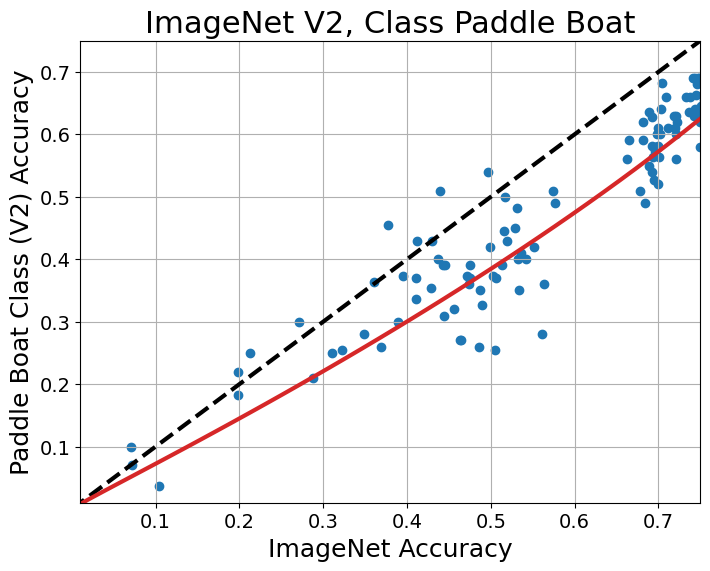

In [13]:
plt.style.use('default')
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


class_i = 693
class_name = classes[class_i].capitalize()[:13]
if class_i == 693:
    class_name = 'Paddle Boat'

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
# plt.scatter(data_v2['x'], data_v2['labels'][i], color='tab:blue')
ax.scatter(all_x, class_z[class_i], color='tab:blue')
ax.plot(np.linspace(0, 0.75, 40), np.linspace(0, 0.75, 40), '--', color='black', linewidth=3)

ax.plot(np.linspace(0, 0.75, 40), y, color='tab:red', linewidth=3)
ax.set_title(f'ImageNet V2, Class {class_name}', fontsize=22)
ax.set_xlabel('ImageNet Accuracy')

ax.set_ylabel(f'{class_name} Class (V2) Accuracy')
plt.grid(True)

ax.set_xlim(0.01, 0.75)
ax.set_ylim(0.01, 0.75)

plt.savefig('figures/acconline_first2.pdf', dpi=100,
        bbox_inches='tight')


plt.show()

In [14]:
img_i = 6932

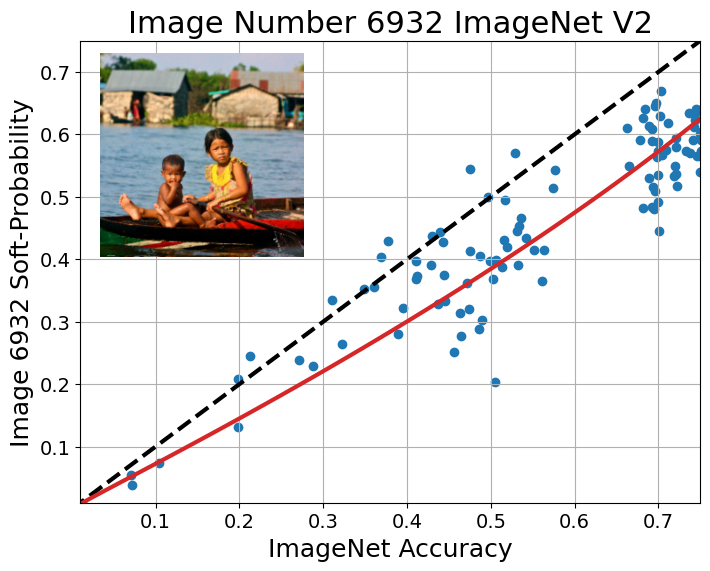

In [25]:

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.scatter(all_x, z[img_i], color='tab:blue')
ax.plot(np.linspace(0, 0.75, 40), np.linspace(0, 0.75, 40), '--', color='black', linewidth=3)
# plt.plot(x, y, color='tab:red', linewidth=3)
ax.plot(np.linspace(0, 0.75, 40), y, color='tab:red', linewidth=3)
ax.set_title(f'Image Number {img_i} ImageNet V2', fontsize=22)
ax.set_xlabel('ImageNet Accuracy')
ax.set_ylabel(f'Image {img_i} Soft-Probability')
ax.grid(True)

ax.set_xlim(0.01, 0.75)
ax.set_ylim(0.01, 0.75)


newax = fig.add_axes([0.15, 0.52, 0.34, 0.34], anchor='NW', zorder=1)
newax.imshow(dataset[img_i][0])
newax.axis('off')


plt.savefig('figures/acconline_first3.pdf', dpi=100,
        bbox_inches='tight')


# plt.legend()
plt.show()

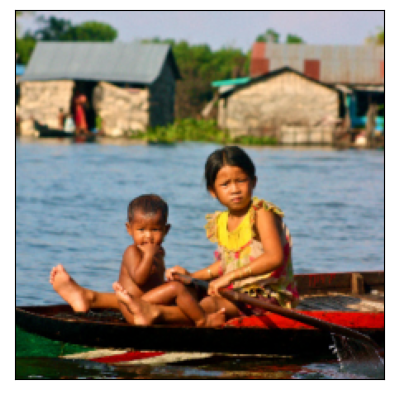

In [17]:
plt.xticks([])
plt.yticks([])
plt.imshow(dataset[img_i][0])
# plt.gcf().axes[0].set_title(f'Image {img_i}, ImageNet V2, ', fontsize=22)
plt.savefig('figures/acconline_image.pdf', dpi=100, bbox_inches='tight')